In [679]:
import pickle
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from line_profiler import LineProfiler

In [ ]:
#tqdm._instances.clear()

In [ ]:
np.random.seed(42)

In [6]:
def norm(x):
    return np.imag(x)**2 + np.real(x)**2

In [192]:
def phase_val(A, X, y):
    sum_val = 0
    for y_i, A_i in zip(y, A):
        trace = np.trace(A_i.dot(X)).real
        sum_val += -y_i * np.log(trace) + trace
    return sum_val

In [576]:
def phase_gradient(A, X, y):
    sum_val = 0
#    A_T = np.conjugate(np.transpose(A, axes=(0, 2, 1)))
#    return np.sum((-y / np.trace(A.dot(X), axis1=1, axis2=2).real)[:, None, None] * A_T + A_T, axis=0)
    for y_i, A_i in zip(y, A):
        sum_val += -y_i * np.conjugate(A_i).T / np.trace(A_i.dot(X)).real + np.conjugate(A_i).T
    return sum_val

In [4]:
def x_norm(A, X, y, u):
    sum_val = 0
    for y_i, A_i in zip(y, A):
        sum_val += y_i * np.trace(A_i.dot(u)).real**2 / np.trace(A_i.dot(X)).real**2
    return np.sqrt(sum_val)

In [585]:
def complex_scalar_dot(A, B):
    return np.trace(np.conjugate(A).T.dot(B)).real

In [697]:
def run_Frank_Wolf(A, X, y, c, tau_policy='standard', num_iter=100, tol=1e-6):
    points = [X]
    gaps = []
    for t in tqdm(range(num_iter)):
        grad = phase_gradient(A, X, y)
        eig_vals, eig_vecs = np.linalg.eigh(grad) # eigh ?
        u_t = eig_vecs[:, np.argmin(eig_vals.real)]
        V_t = c * np.dot(u_t.reshape(-1, 1), np.conj(u_t).reshape(1, -1))
        # scalar product in matrix space
        #gap = np.trace(np.conjugate(X - V_t).T.dot(grad)).real
        gap = complex_scalar_dot(X - V_t, grad)
        if tau_policy == 'standard':
            tau = 2 / (t + 2)
        if tau_policy == 'line_search':
            optim_func = lambda t_val: phase_val(A, (1 - t_val) * X + t_val * V_t, y)
            tau = minimize(optim_func, 0.5, bounds=[(0, 1)]).x
            #print(tau)
        if tau_policy == 'icml':
            e = x_norm(A, X, y, V_t - X)
            tau = min(1, gap / (e * gap + e))
        X_prev = X
        X = (1 - tau) * X + tau * V_t
        #diff_norm = np.sqrt(complex_scalar_dot(X - X_prev, X - X_prev))
        #rdiff = diff_norm / max(1, np.sqrt(complex_scalar_dot(X_prev, X_prev)))
        prev_val = phase_val(A, X_prev, y)
        fdiff = np.abs(prev_val - phase_val(A, X, y)) / np.abs(prev_val)
        points.append(X)
        gaps.append(gap)
        if fdiff < tol:
            print('Convergence achieved')
            print('Function value: %f' % phase_val(A, X, y))
            print('Fdiff: %.2e' % fdiff)
            print('Gap: %.2f' % gap)
            return points, gaps
    print('Function value: %f' % phase_val(A, X, y))
    print('Fdiff: %.2e' % fdiff)
    print('Gap: %.2f' % gap)
    return points, gaps

def compute_residuals(A, y, points, X_sol):
    sol_val = phase_val(A, X_sol, y)
    return [(phase_val(A, X, y) - sol_val) / sol_val for X in points]

Т.к. все матрицы эрмитовы, то операции trace - вещественны, но из-за ошибки округления, надо явно отбрасывать комплексную часть. То же самое для собсвтенных чисел - они вещественны, но надо явно отбрасывать комплексную часть.

In [705]:
# complex case
p = 256
n = 32

mu, sigma = 0, 1
a = np.random.normal(mu, sigma, size=(n, p)) + np.random.normal(mu, sigma, size=(n,p)) * 1j
A = np.array([np.dot(a_i.reshape(-1, 1), np.conj(a_i).reshape(1, -1)) for a_i in a])

x_sol = np.random.normal(0, 1, p) + np.random.normal(0, 1, p) * 1j
X_sol = np.dot(x_sol.reshape(-1, 1), np.conj(x_sol).reshape(1, -1))

lambda_val = [norm(np.vdot(a_i, x_sol)) for a_i in a]

y = np.array([np.random.poisson(lambda_i) for lambda_i in lambda_val])
c = np.mean(y)

x_0 = np.random.normal(0, 1, p) + np.random.normal(0, 1, p) * 1j
X_0 = np.dot(x_0.reshape(-1, 1), np.conj(x_0).reshape(1, -1))

with open('./data/phase_data_' + str(p) + '_' + str(n) + '.pckl', 'wb') as f:
    pickle.dump({'a': a, 'x_sol': x_sol, 'x_0': x_0, 'y': y}, f)

In [712]:
# load data
with open('./data/phase_data_128_32.pckl', 'rb') as f:
    data = pickle.load(f)
    
a = data['a']
x_sol = data['x_sol']
x_0 = data['x_0']
A = np.array([np.dot(a_i.reshape(-1, 1), np.conj(a_i).reshape(1, -1)) for a_i in a])
X_sol = np.dot(x_sol.reshape(-1, 1), np.conj(x_sol).reshape(1, -1))
X_0 = np.dot(x_0.reshape(-1, 1), np.conj(x_0).reshape(1, -1))

y = data['y']
c = np.mean(y)

In [713]:
%%time
points_standard, gaps_standard = run_Frank_Wolf(A, X_0, y, c, num_iter=1000)


Function value: -130455.758208
Fdiff: 6.65e-05
Gap: 4366.50
Wall time: 23.3 s


In [714]:
%%time
points_line_search, gaps_line_search = run_Frank_Wolf(A, X_0, y, c, tau_policy='line_search', num_iter=1000)

Convergence achieved
Function value: -129857.019672
Fdiff: 6.33e-07
Gap: 2724.93
Wall time: 5.64 s


In [715]:
%%time
points_icml, gaps_icml = run_Frank_Wolf(A, X_0, y, c, tau_policy='icml', num_iter=1000)

Convergence achieved
Function value: -127777.526464
Fdiff: 1.75e-07
Gap: 5527.98
Wall time: 12.6 s


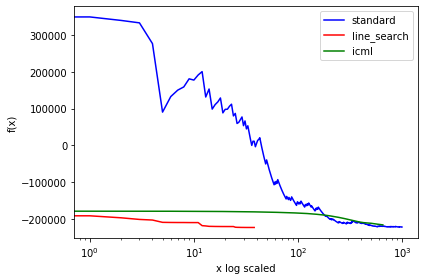

In [710]:
plt.plot([phase_val(A, X, y) for X in points_standard], 'b', label='standard')
plt.plot([phase_val(A, X, y) for X in points_line_search], 'r', label='line_search')
plt.plot([phase_val(A, X, y) for X in points_icml], 'g', label='icml')
plt.legend()
plt.ylabel('f(x)')
plt.xscale('log')
plt.xlabel('x log scaled')
plt.tight_layout()
plt.savefig('./pics/phase_f_' + str(p) + '_' + str(n) + '.png')
plt.show()

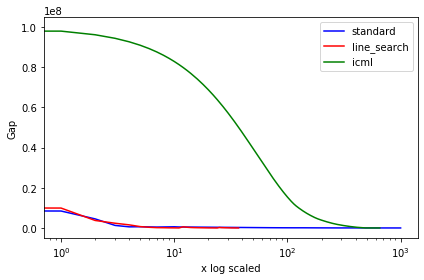

In [711]:
plt.plot(gaps_standard, 'b', label='standard')
plt.plot(gaps_line_search, 'r', label='line_search')
plt.plot(gaps_icml, 'g', label='icml')
plt.xscale('log')
plt.ylabel('Gap')
plt.xlabel('x log scaled')
plt.legend()
plt.tight_layout()
plt.savefig('./pics/phase_gap_' + str(p) + '_' + str(n) + '.png')
plt.show()